# Qiskit: quantum circuit simulation

In [ ]:
#| default_exp platform.simulation.qcircuit_sim

In [ ]:
#| export
from genQC.imports import *

import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.gate import Gate
import qiskit.circuit.library as ql

## Circuit

In [ ]:
#| export
def get_number_of_gate_params(gate_cls):
    return gate_cls.__init__.__code__.co_argcount - len(gate_cls.__init__.__defaults__) - 1 # python: gives you the number of any arguments BEFORE *args, minus ones that have a default, -1 for self parameter of classes

In [ ]:
#| export
def gate_pool_to_gate_classes(gate_pool: list[Gate]): 
    """Creates a vocabulary from a gate pool."""
    classes = {}
    
    for i,cls in enumerate(gate_pool):
        num_of_paramters = get_number_of_gate_params(cls)
        name = cls(*[0]*num_of_paramters).name
        classes[name] = (i+1)
        
    return classes

In [ ]:
#| export
def schmidt_rank_vector(densityMatrix: qi.DensityMatrix):   
    """Return the SRV of a `qi.DensityMatrix`."""
    systems_cnt = len(densityMatrix.dims())   
    total_trace = set(range(systems_cnt))    
    rank_vector = []
    
    for i in range(systems_cnt): 
        trace = list(total_trace - {i})
        red_densityMatrix = qi.partial_trace(densityMatrix, trace)        
        # r = np.count_nonzero(np.linalg.eigvals(red_densityMatrix) > 1e-14) # was slower during testing   
        r = np.linalg.matrix_rank(red_densityMatrix, hermitian=True)       
        rank_vector.append(r)
    
    return rank_vector

In [ ]:
#| export
def rnd_circuit(num_of_qubits, num_of_gates, gate_pool: list[Gate], rng):
    """Create a random circuit."""
    qc = QuantumCircuit(num_of_qubits)    
    gate_indices = rng.choice(len(gate_pool), num_of_gates)
    
    for gate_index in gate_indices:
        gate_qiskit_class = gate_pool[gate_index]
        
        num_of_paramters = get_number_of_gate_params(gate_qiskit_class)
        params           = rng.uniform(low=0, high=2*np.pi, size=num_of_paramters) if num_of_paramters > 0 else [] # random between 0 and 2pi
        
        gate = gate_qiskit_class(*params)      
        act_qubits = rng.choice(num_of_qubits, gate.num_qubits, replace=False) # order: (*act_qubits)=(*control_qubits, *target_qubits)   
        qc.append(gate, [*act_qubits], [])
    
    return qc

In [ ]:
#| export
def optimize_circuit(qc: QuantumCircuit, gate_pool: list[Gate], optimization_level=2):
    """Use qiskit.compiler.transpile to optimize a circuit."""
    basis_gates = gate_pool_to_gate_classes(gate_pool).keys()
    
    while optimization_level > 0:
        try:
            qc_opt = transpile(qc, optimization_level=optimization_level, basis_gates=basis_gates) #target=target
            return qc_opt
        except Exception as er: pass
  
        optimization_level -= 1

    return qc

'Rand: svr=[1, 1, 1]    num_gates=8'

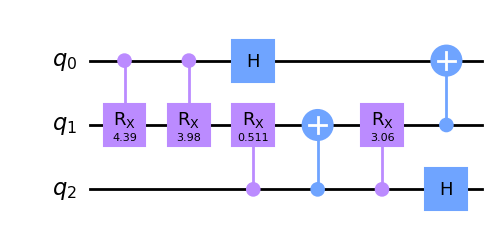

'Opti: svr=[1, 1, 1]    num_gates=8'

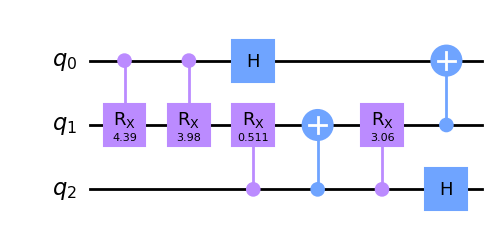

In [ ]:
gs = [ql.HGate, ql.CXGate, ql.CRXGate]
qc = rnd_circuit(num_of_qubits=3, num_of_gates=8, gate_pool=gs, rng=np.random.default_rng())
svr = schmidt_rank_vector(qi.DensityMatrix(qc))
display(f"Rand: svr={svr}    num_gates={len(qc.data)}", qc.draw('mpl'))

qc = optimize_circuit(qc, gs)
svr = schmidt_rank_vector(qi.DensityMatrix(qc))
display(f"Opti: svr={svr}    num_gates={len(qc.data)}", qc.draw('mpl'))

In [ ]:
#| export
def plot_svr_stat(num_of_qubits, min_gates, max_gates, gs, samples, sort=False, opt=True, rng=np.random.default_rng()):    
    svr_list = list()
    for i in range(samples):
        qc = rnd_circuit(num_of_qubits, rng.integers(min_gates, max_gates+1), gs, rng) 
        if opt: qc = optimize_circuit(qc, gs)
        svr = schmidt_rank_vector(qi.DensityMatrix(qc))
        if sort: svr = sorted(svr)
        svr_list.append(svr)           
    df = pd.DataFrame(data={"svr":svr_list})   
    cnts = df['svr'].value_counts(normalize=True)
    for n,v in zip(cnts.index, cnts.values): print(f"{n}: {v*100:.1f}%")    
    df['svr'].value_counts().plot(kind='bar')   

SRV distrubtion for random sampling

[1, 1, 1]: 58.2%
[2, 2, 1]: 11.5%
[2, 2, 2]: 11.3%
[1, 2, 2]: 9.6%
[2, 1, 2]: 9.4%


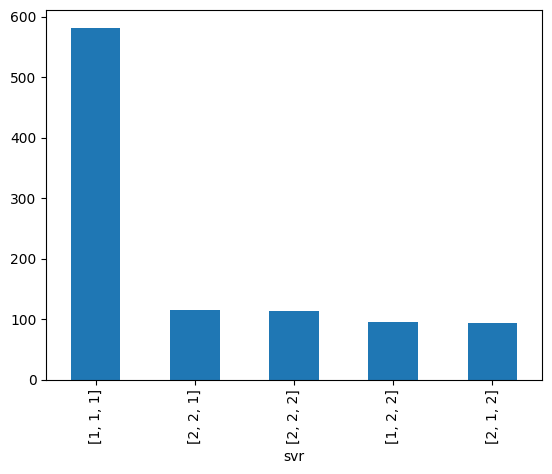

In [ ]:
# gs = [ql.HGate, ql.SGate, ql.TGate, ql.CXGate]  # approx universal set
# gs = [ql.HGate, ql.CCXGate]                     # approx universal set
gs = [ql.HGate, ql.CXGate]

plot_svr_stat(num_of_qubits=3, min_gates=6, max_gates=8, gs=gs, samples=int(1e3),  rng=np.random.default_rng())

## SVR Test cases

In [ ]:
def test_srv(system_dims, init, target):
    vec = qi.Statevector(init, dims=system_dims)
    vec *= 1/np.sqrt(vec.trace())
    srv = schmidt_rank_vector(qi.DensityMatrix(vec)) 
    assert srv == target, f"srv: {srv}"
    print(f"passed test, svr: {srv}")
    display(vec.draw('latex', prefix='|\\psi\\rangle = '))

In [ ]:
#---------------- |0+> = |00>+|01>
system_dims = (2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[1] = 1
test_srv(system_dims, init, [1, 1])

#----------------Bell, |00>+|11>
system_dims = (2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[3] = 1
test_srv(system_dims, init, [2, 2])
  
#----------------GHZ, |000>+|111>
system_dims = (2,2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[7] = 1
test_srv(system_dims, init, [2,2,2])
 
#----------------Sym, |000>+|111>+|222>
system_dims = (3,3,3)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0]  = 1
init[13] = 1
init[26] = 1
test_srv(system_dims, init, [3,3,3])
      
#----------------Wikipedia example, |000>+|101>+|210>+|311>
system_dims = (4,4,4)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0]  = 1
init[17] = 1
init[36] = 1
init[53] = 1
test_srv(system_dims, init, [2, 2, 4])

passed test, svr: [1, 1]


<IPython.core.display.Latex object>

passed test, svr: [2, 2]


<IPython.core.display.Latex object>

passed test, svr: [2, 2, 2]


<IPython.core.display.Latex object>

passed test, svr: [3, 3, 3]


<IPython.core.display.Latex object>

passed test, svr: [2, 2, 4]


<IPython.core.display.Latex object>

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()